<a href="https://colab.research.google.com/github/aadi-mishra/Deep-Learning-Projects-Keras/blob/main/regression_HousingPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on.  The dataset 506 data points split
between 404 training samples and 102 test samples. And each feature in the input data
(for example, the crime rate) has a different scale. For instance, some values are pro-
portions, which take values between 0 and 1; others take values between 1 and 12, oth-
ers between 0 and 100, and so on.

In [27]:
# Importing libraries 
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np 
import pandas as pd

In [28]:
# Loading the dataset 
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [29]:
# Looking at the data
print("Dimension Training Data : ", train_data.shape)
print("Dimension Testing Data : ", test_data.shape)
print(train_data[0])

df = pd.DataFrame(train_data)
df.head(10)

Dimension Training Data :  (404, 13)
Dimension Testing Data :  (102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65
5,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74
6,9.18702,0.0,18.10,0.0,0.700,5.536,100.0,1.5804,24.0,666.0,20.2,396.90,23.60
7,4.09740,0.0,19.58,0.0,0.871,5.468,100.0,1.4118,5.0,403.0,14.7,396.90,26.42
8,2.15505,0.0,19.58,0.0,0.871,5.628,100.0,1.5166,5.0,403.0,14.7,169.27,16.65
9,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41


We have 404 training samples and 102 test samples, each with 13
numerical features, such as per capita crime rate, average number of rooms per dwell-
ing, accessibility to highways, and so on.

The targets are the median values of owner-occupied homes, in thousands of
dollars

In [30]:
print("Minimum House Price : ",min(train_targets))
print("Maximum House Price : ",max(train_targets))

Minimum House Price :  5.0
Maximum House Price :  50.0


The prices are typically between `$5000` and `$50,000`.

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation.

In [31]:
# Preparing Data
print(train_data[1])
mean = train_data.mean(axis=0) # mean of all the columns stored in this list "mean"
train_data -= mean # Elementwise subtraction
std = train_data.std(axis=0) # std deviation od all columns

train_data /= std

test_data -= mean
test_data /= std
print(train_data[1])

[2.1770e-02 8.2500e+01 2.0300e+00 0.0000e+00 4.1500e-01 7.6100e+00
 1.5700e+01 6.2700e+00 2.0000e+00 3.4800e+02 1.4700e+01 3.9538e+02
 3.1100e+00]
[-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
 -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
 -1.32920239]


Note that the quantities used for normalizing the test data are computed using the
training data. You should never use in your workflow any quantity computed on the
test data, even for something as simple as data normalization.

In [42]:
# Building our model

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape = (train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
  return model

Since the size of our dataset is very small a train-test-val split is insufficient to privide a good evaluation of our model, and for one such split we might have a high variance of the validation score. 
In order to avoid this and have a reliable evaluation of our model we can use `k-fold cross validation`.

It consists of splitting the available data into K partitions (typically K = 4 or 5), instanti-
ating K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained. In terms of code, this is straightforward.

In [39]:
# K-fold validation
k=4 
num_val_samples = len(train_data) // k
print(num_val_samples)
num_epochs = 100
all_scores = []

101


In [44]:
for i in range(k):
  print('processing fold#',i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1) * num_val_samples :]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)

  model = build_model()

  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)
  

processing fold# 0
processing fold# 1
processing fold# 2
processing fold# 3


In [45]:
print(all_scores)
print(np.mean(all_scores))

[2.228663444519043, 2.183790922164917, 2.7220911979675293, 2.590508460998535]
2.431263506412506


In [56]:
num_epochs = 500
all_mae_histories = []
# Saving the validation logs at each fold
for i in range(k):
  print('processing fold#', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1) * num_val_samples :]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],train_targets[(i + 1) * num_val_samples:]],axis=0)

  model = build_model()

  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),epochs=num_epochs, batch_size=1, verbose=0)
  print(history.params)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold# 0
{'verbose': 0, 'epochs': 500, 'steps': 303}
processing fold# 1
{'verbose': 0, 'epochs': 500, 'steps': 303}
processing fold# 2
{'verbose': 0, 'epochs': 500, 'steps': 303}
processing fold# 3
{'verbose': 0, 'epochs': 500, 'steps': 303}


Building the history of successive mean K-fold validation scores

In [57]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

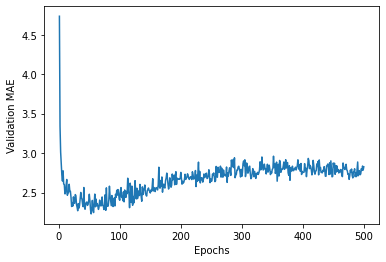

In [58]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high vari-
ance. Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve.

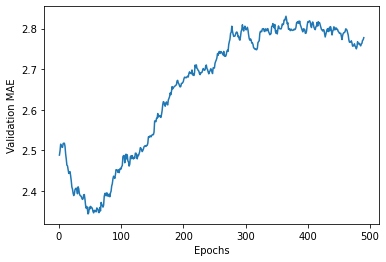

In [60]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs.
Past that point, you start overfitting.

In [63]:
# Training Final Model after tuning the parameters

model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 17.1618 - mae: 2.5638


In [64]:
test_mae_score

2.5638396739959717